## Metrics and example images from simulation at various blur levels

In [1]:
import numpy as np
from skimage.util import invert
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

from chromemt_analysis import parse_simulation_zip, segment_like_paper, continuous_erosion_edt, linear_fit_to_residual_volume, linear_fit_to_residual_volume2

In [2]:
# load regular and irregular chromatin simulations
regular_zip = '/Volumes/davidh-ssd/chromemt_data/simulations/VoxelTestReg.zip'
irregular_zip = '/Volumes/davidh-ssd/chromemt_data/simulations/VoxelTest.zip'

psz, mask_regular = parse_simulation_zip(regular_zip)
_, mask_irregular = parse_simulation_zip(irregular_zip)

# float and invert
mask_regular = mask_regular.astype(np.float32)
mask_regular = invert(mask_regular)
mask_irregular = mask_irregular.astype(np.float32)
mask_irregular = invert(mask_irregular)

In [3]:
mask_irregular.shape

(305, 305, 305)

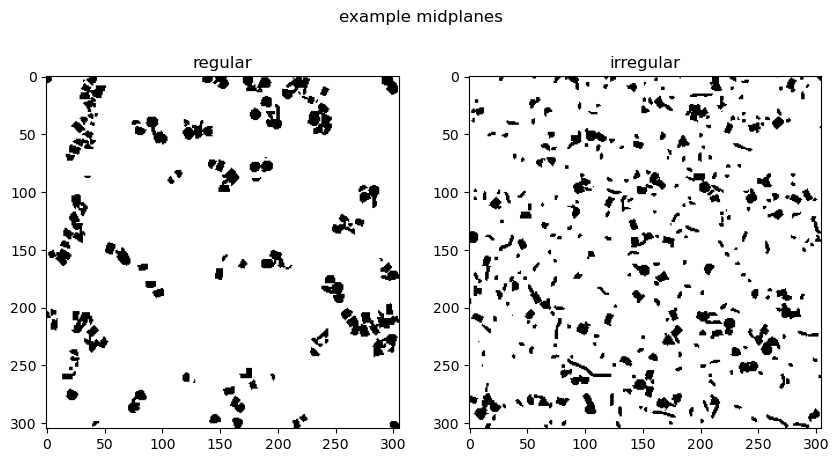

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

axs[0].imshow(mask_regular[mask_regular.shape[0]//2], cmap='gray')
axs[0].set_title('regular')
axs[1].imshow(mask_irregular[mask_irregular.shape[0]//2], cmap='gray')
axs[1].set_title('irregular')
fig.suptitle('example midplanes');

In [5]:
# CVC from raw masks
invert(mask_regular).sum() / mask_regular.size, invert(mask_irregular).sum() / mask_irregular.size

(0.09270671994572233, 0.13155451777902116)

In [6]:
# try segmentation on raw masks
seg_noblur_regular = segment_like_paper(mask_regular)
seg_noblur_irregular = segment_like_paper(mask_irregular)

In [7]:
# CVC from segs
seg_noblur_regular.sum() / seg_noblur_regular.size, seg_noblur_irregular.sum() / seg_noblur_irregular.size 

(0.08978689846286693, 0.0985748410659923)

In [8]:
# blur simulations
sigmas = np.arange(1, 9)

blurred_regular = {s: gaussian_filter(mask_regular, s) for s in sigmas}
blurred_irregular = {s: gaussian_filter(mask_irregular, s) for s in sigmas}

In [9]:
# segment blurs
segmentations_regular = {s: segment_like_paper(b) for s,b in blurred_regular.items()}
segmentations_irregular = {s: segment_like_paper(b) for s,b in blurred_irregular.items()}

In [10]:
# cvcs from blurred images
cvcs_regular = {s: seg.sum() / seg.size for s, seg in segmentations_regular.items()}
cvcs_irregular = {s: seg.sum() / seg.size for s, seg in segmentations_irregular.items()}
cvcs_regular, cvcs_irregular

({1: 0.09325439574237492,
  2: 0.1427716681131901,
  3: 0.18722603213484829,
  4: 0.2286559315537424,
  5: 0.2657825632982496,
  6: 0.29776779554235816,
  7: 0.32330829452685467,
  8: 0.3425471559293509},
 {1: 0.14338983439142483,
  2: 0.294104969138386,
  3: 0.357505412347289,
  4: 0.3798193505183253,
  5: 0.38774921248915106,
  6: 0.3910012203664624,
  7: 0.39169058203109514,
  8: 0.39277712231420253})

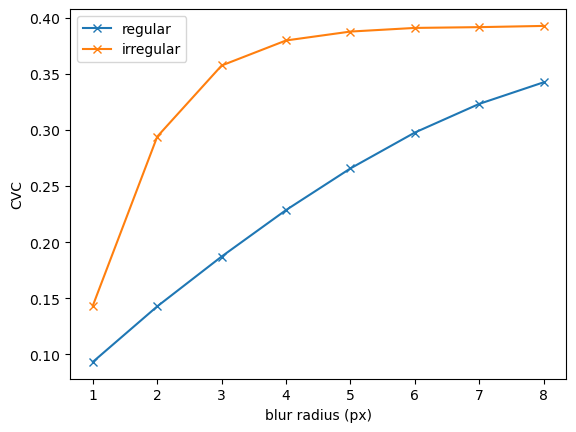

In [11]:
# CVC vs. blur plot

plt.plot(*zip(*cvcs_regular.items()), '-x', label='regular')
plt.plot(*zip(*cvcs_irregular.items()), '-x', label='irregular')
plt.xlabel('blur radius (px)')
plt.ylabel('CVC')
plt.legend()

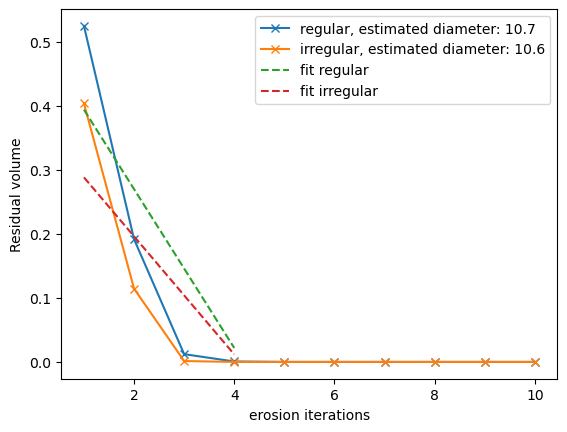

In [13]:
# diameter estimation on unblurred masks

erosion_radii = np.arange(1, 11)
trace_regular = continuous_erosion_edt(invert(mask_regular.astype(bool)), erosion_radii)
trace_irregular = continuous_erosion_edt(invert(mask_irregular.astype(bool)), erosion_radii)

d_regular, lm_regular = linear_fit_to_residual_volume(trace_regular, erosion_radii)
d_irregular, lm_irregular = linear_fit_to_residual_volume(trace_irregular, erosion_radii)

# old yx fit
# d_regular, lm_regular = linear_fit_to_residual_volume2(trace_regular, erosion_radii)
# d_irregular, lm_irregular = linear_fit_to_residual_volume2(trace_irregular, erosion_radii)

plt.plot(erosion_radii, trace_regular, '-x', label='regular, estimated diameter: {:.1f}'.format(d_regular * psz))
plt.plot(erosion_radii, trace_irregular, '-x', label='irregular, estimated diameter: {:.1f}'.format(d_irregular * psz))

# plots for old yx fit
# plt.plot(lm_regular.predict(np.linspace(trace_regular[0],0).reshape(-1,1)), np.linspace(trace_regular[0],0).reshape(-1,1), '--', label='fit regular')
# plt.plot(lm_irregular.predict(np.linspace(trace_irregular[0],0).reshape(-1,1)), np.linspace(trace_irregular[0],0).reshape(-1,1), '--', label='fit irregular')

plt.plot(erosion_radii[erosion_radii < d_regular // 2 + 1],lm_regular.predict(erosion_radii[erosion_radii < d_regular // 2 + 1].reshape(-1,1)), '--', label='fit regular')
plt.plot(erosion_radii[erosion_radii < d_irregular // 2 + 1],lm_irregular.predict(erosion_radii[erosion_radii < d_irregular // 2 + 1].reshape(-1,1)), '--', label='fit irregular')

plt.xlabel('erosion iterations')
plt.ylabel('Residual volume')
plt.legend()

In [14]:
# estimated diameters from blurred
erosion_radii = np.arange(1, 21)

traces_regular = {s: continuous_erosion_edt(b, erosion_radii) for s,b in segmentations_regular.items()}
traces_irregular = {s: continuous_erosion_edt(b, erosion_radii) for s,b in segmentations_irregular.items()}

diameters_regular = {s: linear_fit_to_residual_volume(t, erosion_radii)[0] * psz for s,t in traces_regular.items()}
diameters_irregular = {s: linear_fit_to_residual_volume(t, erosion_radii)[0] * psz for s,t in traces_irregular.items()}

diameters_regular, diameters_irregular

({1: 11.097524630329215,
  2: 12.950265622865068,
  3: 15.735541996624688,
  4: 18.565779449571075,
  5: 21.128884301470887,
  6: 23.385198227203905,
  7: 25.41264325696923,
  8: 27.219566603959258},
 {1: 10.900864198526765,
  2: 12.014602102963455,
  3: 13.792011173177917,
  4: 15.46368414162562,
  5: 16.976660229258474,
  6: 18.65937531454262,
  7: 20.457157811057797,
  8: 22.35896767402764})

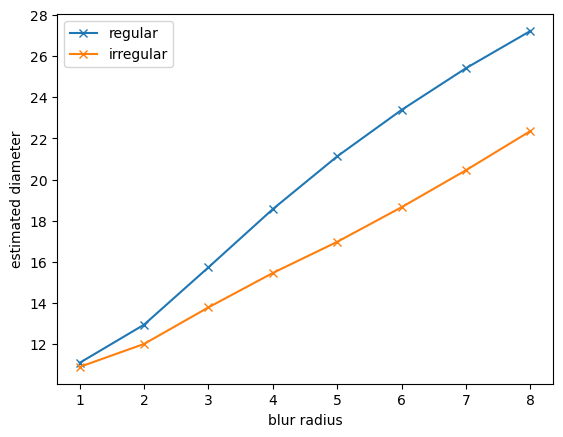

In [15]:
plt.plot(*zip(*diameters_regular.items()), '-x', label='regular')
plt.plot(*zip(*diameters_irregular.items()), '-x', label='irregular')
plt.xlabel('blur radius')
plt.ylabel('estimated diameter')
plt.legend()

Text(0.5, 1.0, 'continuous erosion, irregular')

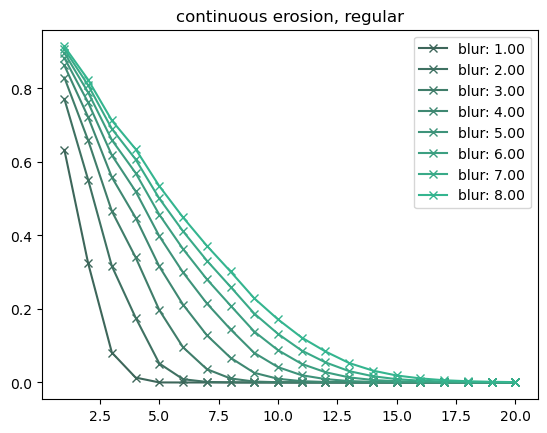

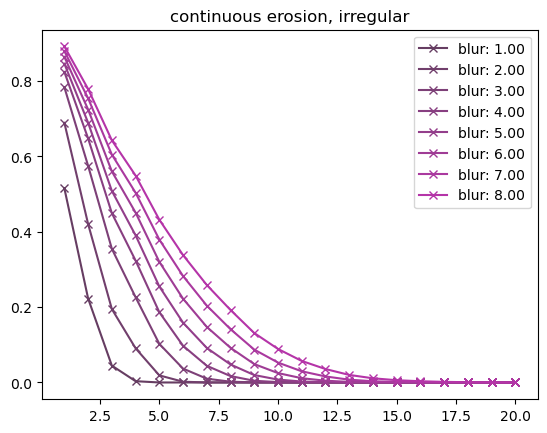

In [16]:
from matplotlib.colors import hsv_to_rgb

h = [0.45]

for (s, tr), sv in zip(traces_regular.items(), np.linspace(0.4, 0.8, len(trace_regular))):
    plt.plot(erosion_radii, tr, '-x', color=hsv_to_rgb(h + [sv] * 2), label='blur: {:.2f}'.format(s))
plt.legend()
plt.title('continuous erosion, regular')


h = [0.85]

plt.figure()
for (s, tr), sv in zip(traces_irregular.items(), np.linspace(0.4, 0.8, len(trace_irregular))):
    plt.plot(erosion_radii, tr, '-x', color=hsv_to_rgb(h + [sv] * 2), label='blur: {:.2f}'.format(s))
plt.legend()
plt.title('continuous erosion, irregular')


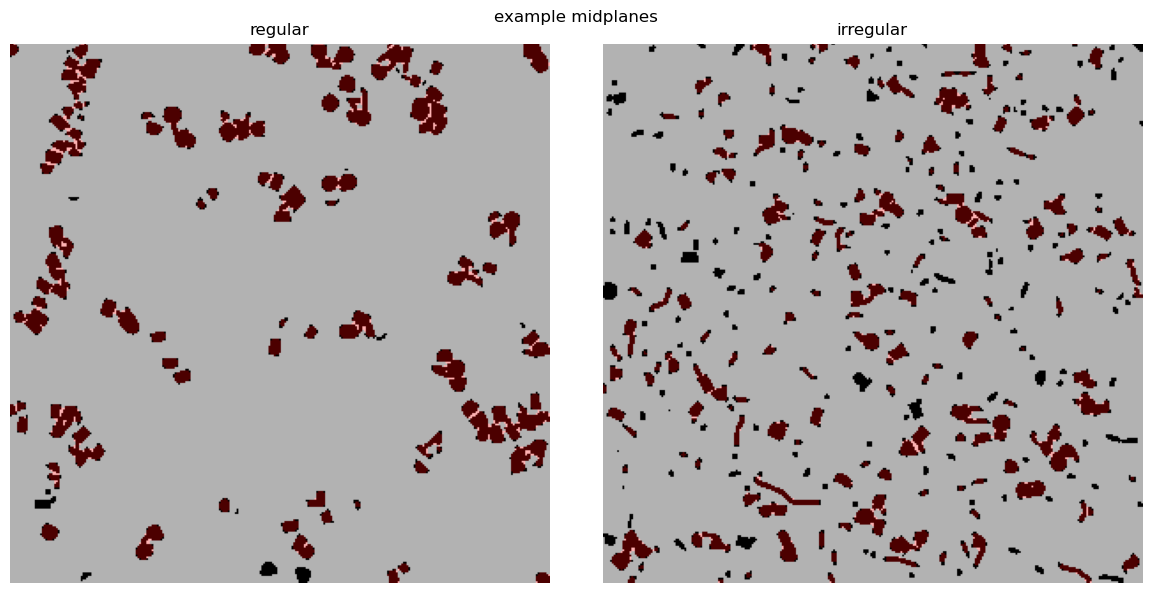

In [ ]:
# plot examples, raw mask and segmentation 

from skimage.color import label2rgb, gray2rgb

overlay_regular = label2rgb(seg_noblur_regular[seg_noblur_regular.shape[0]//2], mask_regular[mask_regular.shape[0]//2], bg_label=0)
overlay_irregular = label2rgb(seg_noblur_irregular[seg_noblur_irregular.shape[0]//2], mask_irregular[mask_irregular.shape[0]//2], bg_label=0)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].imshow(overlay_regular)
axs[0].set_title('regular')
axs[0].axis('off')
axs[1].imshow(overlay_irregular)
axs[1].set_title('irregular')
axs[1].axis('off')
fig.suptitle('example midplanes');
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(12,30))
for ax, (s, b), (_, m) in zip(axs.flat, blurred_regular.items(), segmentations_regular.items()):
    overlay = label2rgb(m[m.shape[0]//2], b[b.shape[0]//2], bg_label=0)
    ax.imshow(overlay)
    ax.set_title('blur: {} px = {:.2f} nm'.format(s, s * psz))
    ax.axis('off')
fig.suptitle('example midplanes regular\n');
fig.tight_layout()


fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(12,30))
for ax, (s, b), (_, m) in zip(axs.flat, blurred_irregular.items(), segmentations_irregular.items()):
    overlay = label2rgb(m[m.shape[0]//2], b[b.shape[0]//2], bg_label=0)
    ax.imshow(overlay)
    ax.set_title('blur: {} px = {:.2f} nm'.format(s, s * psz))
    ax.axis('off')
fig.suptitle('example midplanes irregular\n');
fig.tight_layout()
